# Load Data

In [1]:
import torchvision.datasets as datasets

# Download and extract the PASCAL VOC dataset
train_set = datasets.VOCSegmentation(root='/content/drive/MyDrive/kaggle/pascalVOC', year='2012', image_set='train', download=False)
val_set = datasets.VOCSegmentation(root='/content/drive/MyDrive/kaggle/pascalVOC', year='2012', image_set='val', download=False)

# Accessing the data
train_images = train_set.images
train_labels = train_set.masks
val_images = val_set.images
val_labels = val_set.masks



# Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import torch 
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset , DataLoader

from PIL import Image
from torchvision import transforms 


from torchvision.utils import draw_segmentation_masks
from torchvision.io import read_image
from torchvision.transforms import ToPILImage as toPIL


import torchvision.ops.boxes as box_ops

from torchvision.ops.boxes import masks_to_boxes



## model and weights
from torchvision.models.detection import maskrcnn_resnet50_fpn , MaskRCNN_ResNet50_FPN_Weights

# from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights






device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device



device(type='cpu')

# Utility Functions

In [3]:
def show_img(img , path = False):

  if path :
    img = read_image(img)

  img_pic = toPIL()(img)
  print(f"img shape : {img.shape}")
  img_pic.show()

In [4]:
def show_img_masked(img , masks):
  mask_shape_len =  len(masks.shape)
  if mask_shape_len > 3:
    result = draw_segmentation_masks(img , masks.squeeze(1) > 0.5 ,alpha=0.9 )  
  elif mask_shape_len == 3 :
    result = draw_segmentation_masks(img , masks > 0.5 ,alpha=0.9 )  

  elif mask_shape_len <3 :
    result = draw_segmentation_masks(img , masks.unsqueeze(0) > 0.5 ,alpha=0.9 )  

  else :
    raise Exception(f"Masks dims is invalid : got {masks.shape}")
  plt.imshow(result.permute(1,2,0))


In [5]:
def get_detected_classes(labels ):
  detected ={}
  for idx , key in enumerate(labels.detach().cpu().numpy()):
      detected[idx] = sem_idx_to_class[key]

  return detected


# View the dataset

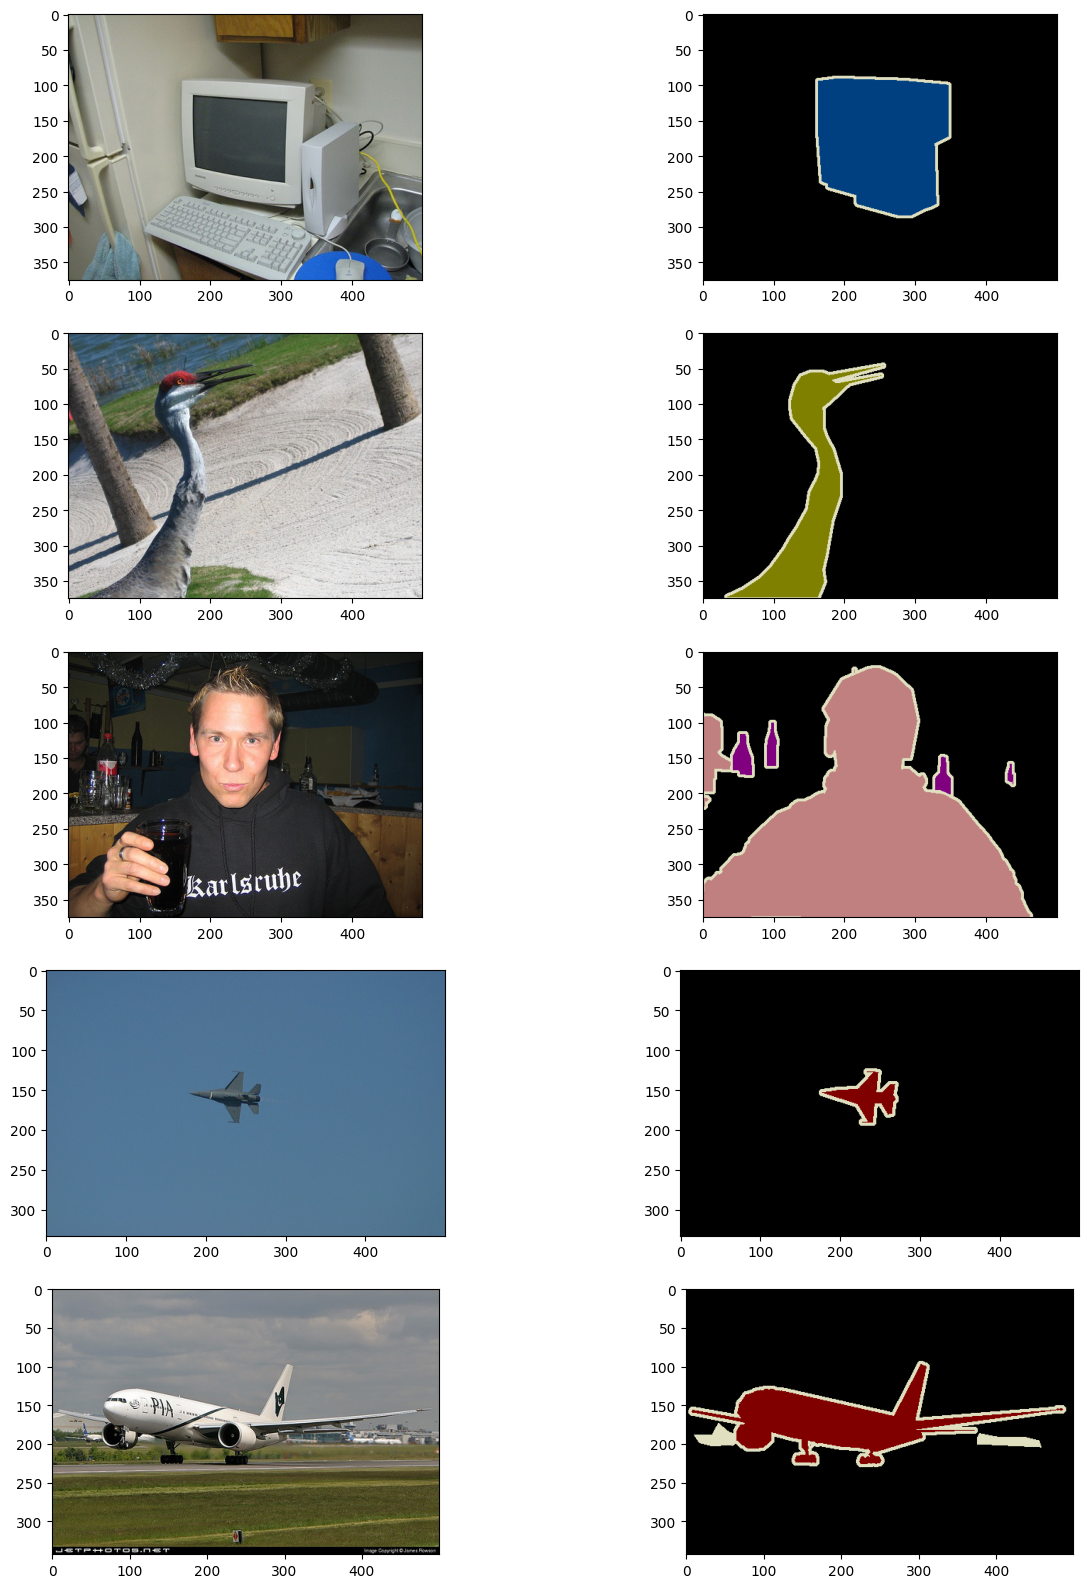

In [ ]:
plt.figure(figsize=(15,20))

for i in range(1,11 , 2):
  plt.subplot(5 , 2 , i)
  plt.imshow(plt.imread(train_images[i]))

  plt.subplot(5 , 2 , i+1)

  plt.imshow(plt.imread(train_labels[i]))
  
  

# Create Custom dataset and dataloaders

In [12]:


class MyDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform =  transforms.Compose([
            transforms.Resize((300, 300)),
            # transforms.ToTensor()
        ])


    def __getitem__(self, index):
        # Load image and label from file
        image = read_image(self.image_paths[index])
        label = read_image(self.label_paths[index])

        # Apply transformation to convert image and label to tensors
        image_tensor = self.transform(image)
        label_tensor = self.transform(label)

        # Return image and label tensors
        return image_tensor, label_tensor

    def __len__(self):
        return len(self.image_paths)

train_ds =  MyDataset(train_images , train_labels )
test_ds  = MyDataset(val_images , val_labels )


## create data loaders 



train_dl = DataLoader(train_ds , batch_size = 4 , shuffle = True)
test_dl  = DataLoader(train_ds , batch_size = 32 ,shuffle = False)

In [13]:
batch = next(iter(train_dl))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [23]:
batch[0]

tensor([[[[ 67,  67,  68,  ...,  78,  82,  68],
          [ 67,  70,  70,  ..., 106,  91,  72],
          [ 72,  69,  68,  ..., 107,  95,  76],
          ...,
          [ 75,  74,  75,  ..., 105, 106, 105],
          [ 70,  71,  74,  ..., 100, 105, 100],
          [ 73,  71,  72,  ...,  96, 100,  85]],

         [[ 73,  74,  73,  ...,  67,  71,  56],
          [ 73,  76,  76,  ...,  92,  81,  61],
          [ 78,  75,  74,  ...,  94,  82,  62],
          ...,
          [ 63,  62,  65,  ...,  75,  75,  73],
          [ 59,  60,  62,  ...,  69,  73,  66],
          [ 60,  60,  61,  ...,  66,  65,  47]],

         [[ 98,  93,  93,  ...,  60,  66,  54],
          [ 99, 100,  97,  ...,  80,  73,  57],
          [ 95,  99,  98,  ...,  81,  77,  60],
          ...,
          [ 63,  62,  64,  ...,  64,  61,  60],
          [ 57,  58,  61,  ...,  59,  61,  56],
          [ 59,  58,  59,  ...,  56,  56,  39]]],


        [[[124, 116, 121,  ..., 104, 100, 105],
          [130, 122, 127,  ..., 107

img shape : torch.Size([3, 300, 300])


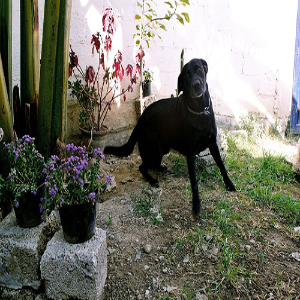

img shape : torch.Size([1, 300, 300])


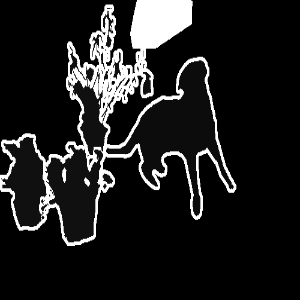

In [156]:

show_img(batch[0][0])


show_img(batch[1][0])

# MASK RCNN

In [8]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights = weights)
sem_idx_to_class = {idx: cls for (idx, cls) in enumerate(weights.meta["categories"])}



model.to(device);

In [ ]:
weights.meta["categories"]

In [36]:
model.eval()
output = model(batch[0]/255)

In [222]:
output[0]["masks"].shape

torch.Size([16, 1, 300, 300])

In [198]:
get_detected_classes(output[0]["labels"])

{0: 'potted plant',
 1: 'dog',
 2: 'potted plant',
 3: 'vase',
 4: 'potted plant',
 5: 'potted plant',
 6: 'potted plant',
 7: 'potted plant',
 8: 'potted plant',
 9: 'vase',
 10: 'horse',
 11: 'cat',
 12: 'vase',
 13: 'vase',
 14: 'potted plant',
 15: 'potted plant'}

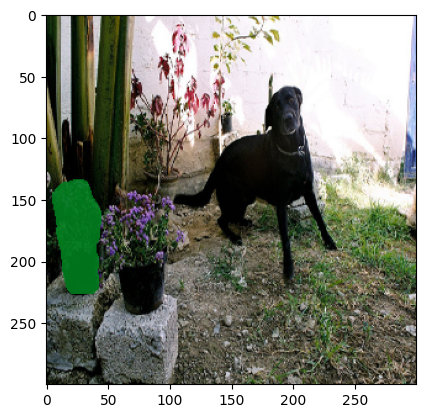

In [238]:
show_img_masked(batch[0][0] , output[0]["masks"][[5,2]] )

# Creating FCN 

In [ ]:
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


In [ ]:
output = model(batch[0][0].unsqueeze(0))

In [ ]:
output

In [ ]:

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


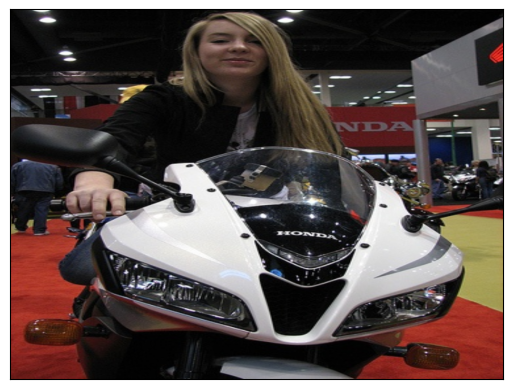

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
# from pathlib import Path

dog1_int = read_image(train_images[220])  #read_image("/content/golden-retriever-royalty-free-image-506756303-1560962726.jpg")
dog2_int = read_image(train_images[0]) # read_image("/content/Husky.jpg")

transform = torchvision.transforms.Resize([600,800
                                           ])

dog1_int =transform(dog1_int)

dog2_int =transform(dog2_int)

dog_list = [dog1_int]

grid = make_grid(dog_list)
show(grid)

In [ ]:
dog_list[0].shape

torch.Size([3, 600, 800])

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 600, 800]) -5.867392063140869 12.480232238769531


In [ ]:
batch.shape

torch.Size([1, 3, 600, 800])

In [ ]:
output.shape

torch.Size([1, 21, 600, 800])

In [ ]:
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

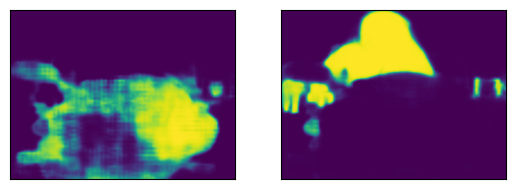

In [ ]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('motorbike','person')
]

show(dog_and_boat_masks)

In [ ]:
normalized_masks.shape


torch.Size([1, 21, 600, 800])

shape = torch.Size([1, 600, 800]), dtype = torch.bool


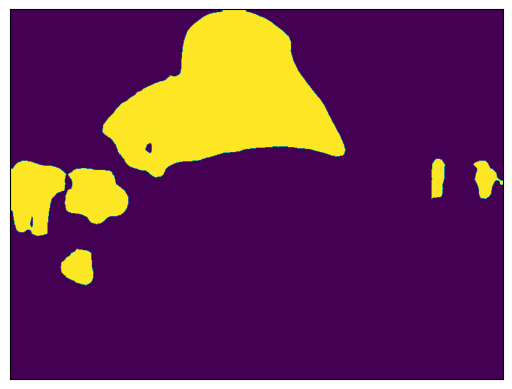

In [ ]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['person'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

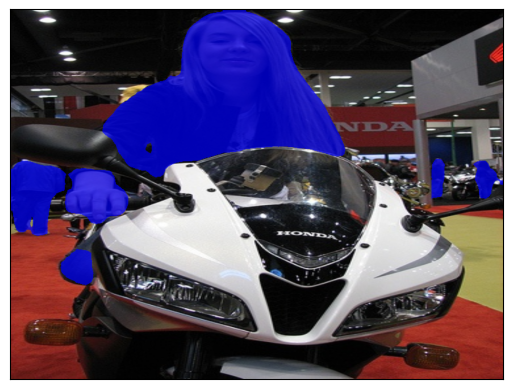

In [ ]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7  ,colors='blue')
    for img, mask in zip(dog_list, boolean_dog_masks)
]
show(dogs_with_masks)

img shape : torch.Size([3, 281, 500])


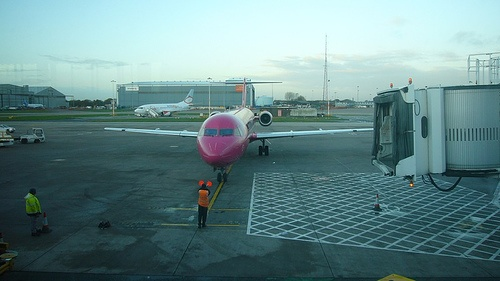

In [ ]:
show_img(train_images[0])

In [ ]:
model.eval()
output = model(img.unsqueeze(0).to(device)/255)
output

In [ ]:
classes[[output[0]["labels"].detach().cpu().numpy() ] ]

KeyError: ignored

In [ ]:
img.shape  , img.dtype

(torch.Size([281, 500, 3]), torch.float32)

In [ ]:
output[0]["labels"].cpu().numpy()

array([ 1,  5,  1,  8,  5,  1,  5,  3,  8,  3,  9, 33,  5,  8, 15,  5,  1,
        3,  1, 82, 41, 82, 44,  5, 33, 41,  5,  9,  8, 44,  5, 41,  5,  1,
       10,  1,  3,  8])

In [ ]:
output[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [ ]:
output[0]["boxes"].shape , output[0]["masks"].shape

(torch.Size([38, 4]), torch.Size([38, 1, 281, 500]))

In [ ]:
from torchvision.utils import draw_bounding_boxes
# img = img.type(torch.uint8).permute(2,0,1)
results = draw_bounding_boxes(img, output[0]["boxes"].detach().cpu() , labels = ["class"]*35  )

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(results.permute(1,2,0))

<Axes: >

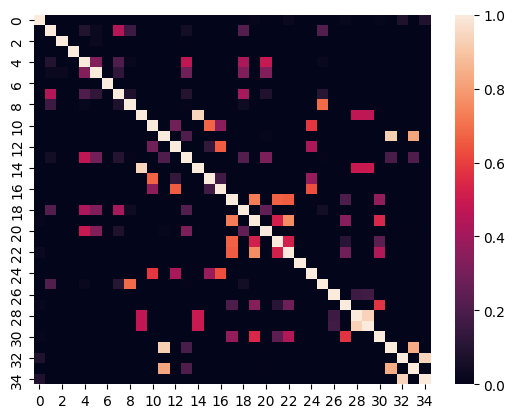

In [ ]:


sns.heatmap(box_ops.box_iou(output[0]["boxes"] , output[0]["boxes"]).detach().cpu().numpy())

In [ ]:
def nms(model_output , thresh):
  boxes ,  labels , scores , masks = model_output[0].values()

  detected_classes = classes[[labels.detach().cpu().numpy()]]

  for obj in detected_classes:
    temp_scores = scores[[]]

  iou = box_ops.box_iou(masks ,  ) 

<ipython-input-171-ed1b9ab47e47>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  detected_classes = dict(zip(classes[[labels.detach().cpu().numpy()]],labels.detach().cpu().numpy() ))


tensor([[1.0000],
        [0.0801],
        [0.0229],
        [0.0000],
        [0.2149],
        [0.0509],
        [0.0049],
        [0.3173],
        [0.0000]], device='cuda:0')


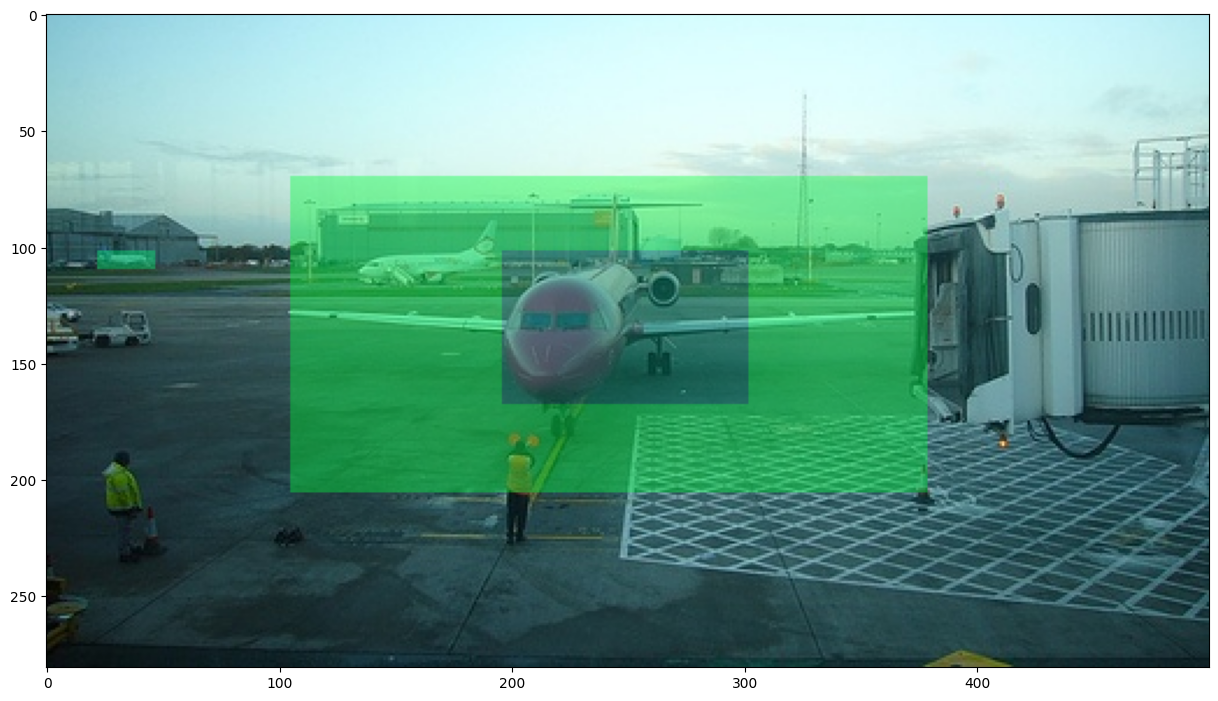

In [ ]:
boxes ,  labels , scores , masks = output[0].values()


def show_masks_for_cat(masks , labels ,scores , class_idx = 0 , nms_thresh = 0.7 , print_iou = False):

      ## dict of classes in image and their label
      detected_classes = dict(zip(classes[[labels.detach().cpu().numpy()]],labels.detach().cpu().numpy() ))


      ## get indices for each class detections one by one 
      indices = torch.nonzero(torch.eq(labels ,list(detected_classes.values())[class_idx] ))


      ## mask 
      temp_masks = masks[indices].squeeze(1,2)

      highest_score_mask = temp_masks[scores[indices].argmax()]

      temp_masks_boxes  = masks_to_boxes(temp_masks)

      highest_score_mask_box = masks_to_boxes(highest_score_mask.unsqueeze(0))


      iou = box_ops.box_iou(temp_masks_boxes , highest_score_mask_box)

      nms_res = box_ops.nms(temp_masks_boxes , iou.ravel() , nms_thresh)

      # temp_masks[nms_res]

      if print_iou:
        print(iou)

      show_img_masked(img , temp_masks[nms_res],)

show_masks_for_cat(masks , labels , scores ,1 , 0.3 , print_iou = True)

In [ ]:
temp_masks_boxes

tensor([[ 23., 186.,  43., 237.],
        [196., 181., 211., 228.],
        [ 97., 219., 111., 229.],
        [370., 145., 395., 177.],
        [ 42., 211.,  49., 231.],
        [  0., 229.,   9., 256.],
        [ 39., 208.,  50., 234.]], device='cuda:0')

In [ ]:
temp_masks_boxes[[1,0,2]]

tensor([[196., 181., 211., 228.],
        [ 23., 186.,  43., 237.],
        [ 97., 219., 111., 229.]], device='cuda:0')

In [ ]:
masks_to_boxes(highest_score_mask.unsqueeze(0))

tensor([[ 23., 186.,  43., 237.]], device='cuda:0')

In [ ]:
IOUs = []

for m in temp_masks:
  print(m.shape,highest_score_mask.shape)
  IOUs.append(box_ops.box_iou(highest_score_mask , m))

torch.Size([281, 500]) torch.Size([281, 500])


RuntimeError: ignored

# Dicovering How draw segmentation mask fn work

## Some tries to do the masking by myself

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the image
# image = Image.open('image.jpg')

# Convert the image to a tensor
image_tensor = batch[0][0]


# Multiply the image tensor with the mask tensor element-wise


masked_tensor = torch.mul(image_tensor, output[0]["masks"][4])

# Convert the masked tensor back to an image
masked_image = transforms.ToPILImage()(masked_tensor)


masked_image

In [ ]:
def draw_masks(image, instances, cmap='tab20'):
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(instances)))
    for i, instance in enumerate(instances):
        mask = instance.detach().cpu().numpy()
        color = colors[i]
        color = torch.tensor(color[:3])
        image[mask] = 0.5 * color + 0.5 * image[mask]
    return image

draw_masks(batch[0][0] , output[0]['masks'][0])

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


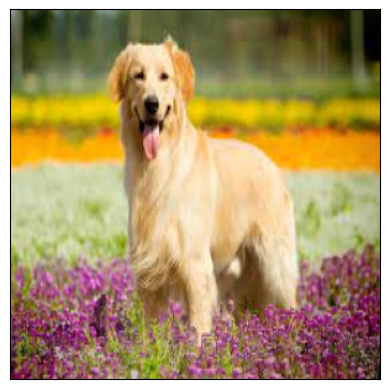

In [53]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

dog1_int = read_image("/content/dog1.jpg")
dog2_int = read_image("/content/dog2.jpg")

dog1_int = transform(dog1_int)
dog2_int = transform(dog2_int)

dog_list = [dog1_int]

grid = make_grid(dog_list)
show(grid)

In [54]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
print(outputs)

[{'boxes': tensor([[ 78.2584,  21.1858, 237.9681, 279.6356],
        [ 71.6034,  24.9112, 261.7554, 283.6913],
        [ 78.8047,  29.6316, 240.3820, 274.0982],
        [ 80.5458,  16.4590, 233.7184, 274.9430]], grad_fn=<StackBackward0>), 'labels': tensor([18, 19, 21,  1]), 'scores': tensor([0.9608, 0.2397, 0.1649, 0.0729], grad_fn=<IndexBackward0>)}]


In [ ]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(dog_list, outputs)
]
show(dogs_with_boxes)

In [55]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 300, 300]) -5.45916748046875 13.663885116577148


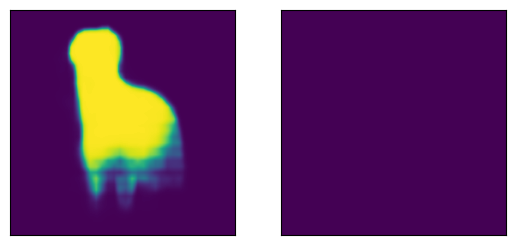

In [56]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

shape = torch.Size([1, 300, 300]), dtype = torch.bool


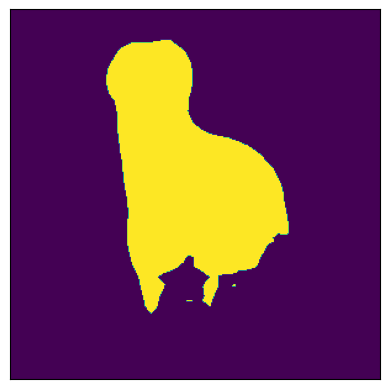

In [57]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])         ## getting argmax between all masks then finding out which one corrspends to dog mask 
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

In [60]:
normalized_masks.shape

torch.Size([1, 21, 300, 300])

In [58]:
boolean_dog_masks.shape

torch.Size([1, 300, 300])

In [80]:
a = torch.randint(10,size = (1,3,4,4))
a 

tensor([[[[9, 1, 2, 0],
          [0, 9, 2, 2],
          [6, 1, 7, 9],
          [6, 3, 2, 5]],

         [[8, 8, 6, 8],
          [5, 5, 0, 3],
          [1, 5, 1, 8],
          [0, 7, 0, 6]],

         [[9, 7, 7, 5],
          [3, 6, 2, 8],
          [3, 8, 3, 2],
          [2, 6, 0, 4]]]])

In [89]:
a.argmax(1) == 1 

tensor([[[False,  True, False,  True],
         [ True, False, False, False],
         [False, False, False, False],
         [False,  True, False,  True]]])

# In conclusion the `draw_segmentation_masks` function from pytorch needs the orginal Image and the mask to work but the trick is the mask tensor returns to you from the mask RCNN model I used above is  usually in the shape of `(N , C , W ,H)` - * Which **WHICH IS NOT THE SAME AS FCN MODEL** Not sure if this the case for all segmentation models* -  but dont fall for the same mistake like me and think that every tensor from ` N  ` corrspends to a a specific mask , apperantly it doesn't , According to the official [Docs](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)  from pytorch you have to perform argmax operation on the masks level ` N ` and get the boolean  mask you need for the function in discuss by equalling it to the index of the category you seek , you can get the dict of these index-categories from the ` model weights ` as done above in ` sem_class_to_index `

# As for the mask RCNN model you only need to use a threshold `0.5` for each mask to get the mask exactly and not a bounding box

## Happy Segmentation

## Good Ref :
  https://www.analyticsvidhya.com/blog/2023/02/mask-r-cnn-for-instance-segmentation-using-pytorch/